In [1]:
import data_engine
from feature_extractor.core import load_extractor_config,extract_feature 
from framework import use_analyzer_on_stock_of_the_date,use_analyzer_on_the_date,extract_stock_feature,load_extracted_feature,prepare_stock_data,load_analyzer_record,use_analyzer_on_stock
import analyzer
from analyzer.core import load_analyzer_config,prepare_data,split_cv,get_X,get_Y
from analyzer.target import tri_trend
from analyzer.metrics import show_nclass_metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np


/home/wanw/tmp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/wanw/tmp/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
record_path = "records/v2"

In [ ]:
#analyzer = load_analyzer_record(record_path)
#df,y=use_analyzer_on_the_date(analyzer,'2018-02-27')

In [ ]:
#df['VMA5']

In [4]:
analyzer = load_analyzer_record(record_path)
analyzer_config_file = analyzer.get('analyzer_config_file')
data_config_file = analyzer.get('data_config_file')
feature_config_file = analyzer.get('feature_config_file')
model = analyzer.get('model')
analyzer_config = load_analyzer_config(analyzer_config_file)

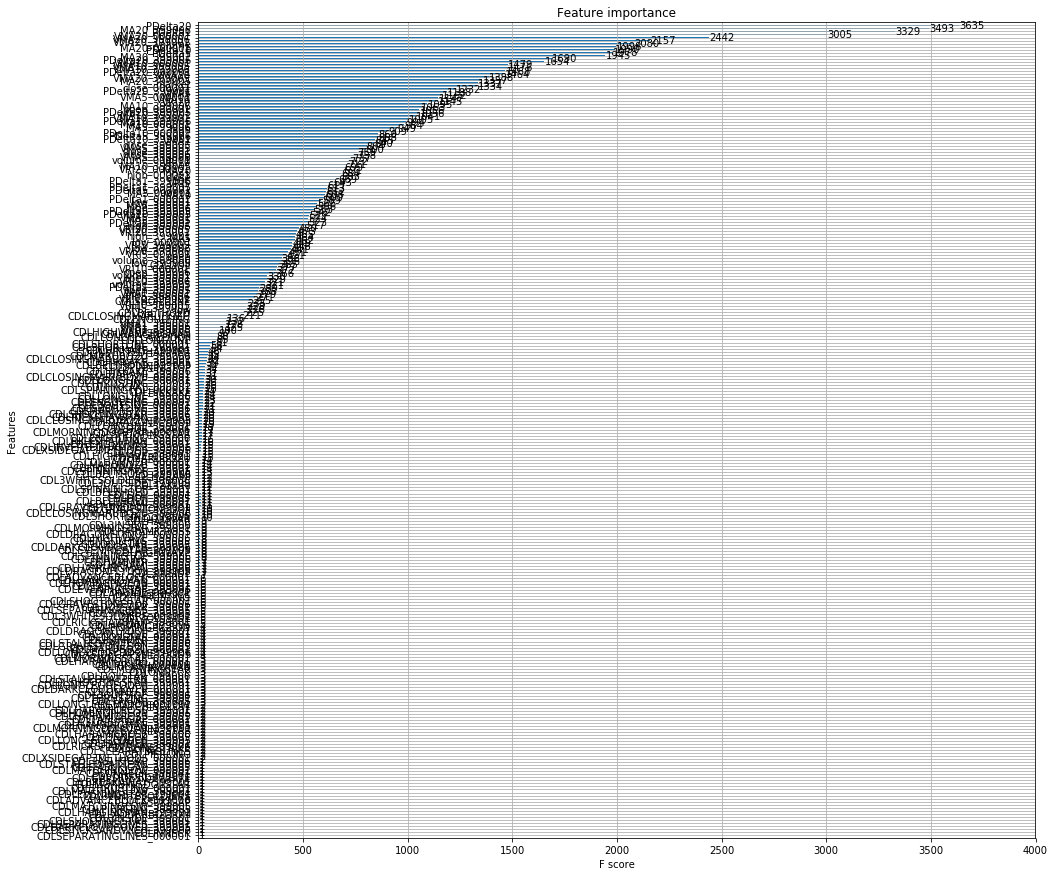

In [5]:
model.display()

In [6]:
print(model.model.get_fscore())

{'MA20_399006': 3493, 'MA10_399001': 1056, 'VMA5_000001': 1162, 'VMA20': 1464, 'VRI5': 643, 'PDelta5': 1978, 'MA20_399005': 1357, 'VMA20_399006': 2442, 'MA20_000001': 1998, 'PDelta1': 3329, 'PDelta20_399006': 1690, 'close_399006': 759, 'PDelta20_000001': 1468, 'close_399001': 800, 'VMA10_399006': 1476, 'VRI10': 722, 'VMA5_399006': 758, 'VMA10_399001': 1041, 'volume': 2080, 'VMA5': 1188, 'PDelta10_000001': 909, 'VMA5_399005': 804, 'VRI20_000001': 699, 'volume_000001': 737, 'PDelta10_399006': 1005, 'open_399006': 372, 'high_399006': 566, 'PDelta20': 3635, 'high_000001': 684, 'market': 1337, 'VMA20_399001': 2157, 'MA5_000001': 612, 'VRI20': 1145, 'close_000001': 1334, 'low_399001': 589, 'CDLSPINNINGTOP_399005': 14, 'MA10_399006': 1095, 'open': 421, 'CDLDOJISTAR': 10, 'PDelta1_000001': 600, 'VMA10_000001': 1654, 'VRI10_399006': 329, 'VRI5_000001': 431, 'PDelta5_399005': 553, 'open_399005': 289, 'VMA20_399005': 1388, 'MA20': 691, 'MA10_399005': 711, 'PDelta20_399005': 1056, 'PDelta10': 1990

In [ ]:
codes = ['603019.SH','000333.SZ','000651.SZ']

In [ ]:
for code in codes:
    df,y = use_analyzer_on_stock(code,analyzer,'2016-01-01','2019-03-07')
    plt.plot(df.date,df.close,color='lightblue')
    df['y']=y
    sell = df[df.y==0]
    buy = df[df.y==2]
    plt.scatter(sell.index,sell.close,marker='x',color='green')
    plt.scatter(buy.index,buy.close,marker='o',color='red')
    #plt.scatter(df.index*(y==2),df.close*(y==2),marker='+')
    plt.show()

In [13]:
#df,y = use_analyzer_on_stock('603019',analyzer,'2016-01-01','2019-02-28')

2016-01-01
2019-02-28
<module 'feature_extractor.features.ta' from '/home/wanw/stockAnalyze/feature_extractor/features/ta.py'>
<module 'feature_extractor.features.ta' from '/home/wanw/stockAnalyze/feature_extractor/features/ta.py'>
get k data 2016-01-01 2019-02-28
{'db': 'mysql', 'host': '10.0.50.143', 'port': 3306, 'user': 'wanw', 'password': '111111', 'schema': 'Stock'}


/home/wanw/tmp/anaconda3/lib/python3.6/site-packages/pymysql/cursors.py:170: Warning: (1287, "'@@tx_isolation' is deprecated and will be removed in a future release. Please use '@@transaction_isolation' instead")
  result = self._query(query)


2016-01-04
2019-02-28


/home/wanw/tmp/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/wanw/tmp/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


2016-01-04
2019-02-28
<module 'feature_extractor.features.ta' from '/home/wanw/stockAnalyze/feature_extractor/features/ta.py'>
<module 'feature_extractor.features.ta' from '/home/wanw/stockAnalyze/feature_extractor/features/ta.py'>
{'db': 'mysql', 'host': '10.0.50.143', 'port': 3306, 'user': 'wanw', 'password': '111111', 'schema': 'Stock'}
2016-01-04
2019-02-28


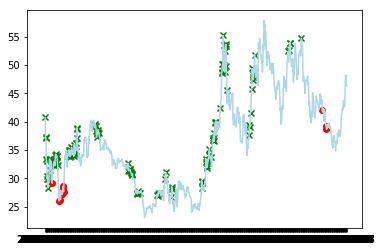

In [14]:
#fig,ax = plt.subplots(figsize=(15,15))
plt.plot(df.date,df.close,color='lightblue')
df['y']=y
sell = df[df.y==0]
buy = df[df.y==2]
plt.scatter(sell.index,sell.close,marker='x',color='green')
plt.scatter(buy.index,buy.close,marker='o',color='red')
#plt.scatter(df.index*(y==2),df.close*(y==2),marker='+')
plt.show()

In [ ]:
buy

In [ ]:
df